# FAST_TFRS recommendation engine

`fast_tfrs` is a deep learning recommendation engine for fast experimentations and productionization.

Built on Google Tensorflow Recommendation Systems [tfrs](https://www.tensorflow.org/recommenders), fast_tfrs aims to be:

- easy-to-use: no boiler-plate coding required, simple API to follow
- easy-to-rebuild (custom): modules are lego-like, ready to be mixed and match
- end-to-end: input raw data output predictions
- stable and scalable for production

To be specific, I contrast the feature differences between `tfrs` and `fast_tfrs` as follow:

- feature encoding
  - `tfrs` requires writting code to encode each feature used in the recommendation, making it not scalable and error-prone in case we have many features
  - `fast_tfrs` automates the encoding for all selected features, making it a bleeze for large scale experimentations.

- feature dtype
  - `tfrs` requires expertise to encode feature of different data-types, include cnt(continuous feature), cat(categorical feature), txt(text feature), img (image feature), dt(datetime feature)
  - `fast_tfrs` provides helpers to automatically separate features of different data-types and corresponding encoders for each type.

- feature selection
  - `tfrs` provides no tools
  - `fast_tfrs` provides tools to select relevant features, at this release include L1, VSN

- feature crossing
  - `tfrs` provides no tools 
  - `fast_tfrs` provides tools for feature crossing (i.e. feature interactions), at this release includes DeepCrossLayer, vsn_DeepCrossLayer

- multitask
  - `tfrs` provides 2 tasks -- ranking and retrieval
  - `fast_tfrs` provides 3 tasks -- ranking, retrieval and classification (for imbalanced multiclass data)

`fast_tfrs` is under active development and welcomes your contribution. For recent updates, please visit https://github.com/wjlgatech/fast_tfrs


## install & load packages

In [1]:
#@title install packages
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
#!pip install -q scann #not needed at this point
!pip install -q tensorflow-ranking
!pip install lshashpy3 #for fast knn search by approximation
!pip install bayesian-optimization # for hyperparameter tuning
!pip install keras_tuner # for hyperparameter tuning
!pip install tensorflow-addons #for extra metrics e.g. tfa.losses.SigmoidFocalCrossEntropy
!pip install focal-loss #for imbalanced classification REF:https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.SparseCategoricalFocalLoss.html#focal_loss.SparseCategoricalFocalLoss

!pip install -U ray 

     |████████████████████████████████| 85 kB 1.8 MB/s 
     |████████████████████████████████| 4.3 MB 5.3 MB/s 
     |████████████████████████████████| 98 kB 4.0 MB/s 
     |████████████████████████████████| 141 kB 5.0 MB/s 
     |████████████████████████████████| 511.7 MB 5.2 kB/s 
     |████████████████████████████████| 438 kB 42.0 MB/s 
     |████████████████████████████████| 1.6 MB 46.2 MB/s 
     |████████████████████████████████| 5.8 MB 33.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for lshashpy3: filename=lshashpy3-0.0.8-py3-none-any.whl size=8903 sha256=d77384dbd6f5b4a3be6eaca7057b4833567d7ecbdbbe51de52ae9dff596a6463
  Stored in directory: /root/.cache/pip/wheels/32/9b/ae/27f94ba2cd85b1cd5af645fa78f90b703c9e1fb9e2b55a04e0
Successfully built lshashpy3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=

In [2]:
#@title install fast_tfrs
url = f"git+https://github.com/wjlgatech/fast_tfrs.git"
!pip install --upgrade {url}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/wjlgatech/fast_tfrs.git to /tmp/pip-req-build-ie5a3kvg
  Running command git clone -q https://github.com/wjlgatech/fast_tfrs.git /tmp/pip-req-build-ie5a3kvg
  Created wheel for fast-tfrs: filename=fast_tfrs-0.0.1-py3-none-any.whl size=76959 sha256=06086fee48b25a08319eb90078eec7a3d2af517b4d2efc0bad9fac9ecc95e9eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-xv7nu9ev/wheels/99/2d/5e/ff900787b225d9aca4c1d6beb3e03c34509f85d7f8f95584b8
Successfully built fast-tfrs


In [3]:
#@title import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_ranking as tfr

#metric for imbalanced multi-class classification REF: https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.SparseCategoricalFocalLoss.html#focal_loss.SparseCategoricalFocalLoss
from focal_loss import SparseCategoricalFocalLoss
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from datetime import datetime
from scipy.stats import mannwhitneyu
from lshashpy3 import LSHash
from tqdm import notebook
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict, Text
import re
import pathlib
import shutil
import tempfile

# pretty display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
from IPython.display import display
#display(result_df)
plt.rcParams['figure.figsize'] = (12, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from  IPython import display

In [4]:
#@title import fast_tfrs functions
from fast_tfrs.core import *

## Dataset

The [original datasets](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) are available in Kaggle provided by Olist, a Brazilian eCommerce platform.

This dataset contains many user-features (e.g. `u_cols`) and many item-features (e.g. `i_cols`), with `label` as `review_score`, showing how high users rate items.

In this [colab notebook](https://drive.google.com/file/d/1xk77zNZAIUNR66GVIbllEl38QSwOP6T7/view?usp=sharing), I merged several tables into one that contains user features, item features, and features about user-item interactions.
 


In [11]:
# load item user interaction data 'iu'
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
datetime_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date']

nrows = 10**3 #select a small data for fast prototyping             
# by default, pd.read_csv read datetime feature as object, which need to be corrected by adding 2 args: parse_dates and date_parser
iu = pd.read_csv("https://raw.githubusercontent.com/wjlgatech/fast_tfrs/master/data/retail_samples_5k.csv",  
                 index_col=0, 
                 nrows=nrows,
                 parse_dates=datetime_cols,
                 date_parser=custom_date_parser,
                 )
iu.head()

,customer_city,customer_id,customer_state,customer_unique_id,customer_zip_code_prefix,freight_value,month,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_id,order_item_id,order_purchase_timestamp,order_status,payment_installments,payment_sequential,payment_type,payment_value,price,product_category_name_english,product_description_lenght,product_height_cm,product_id,product_length_cm,product_name_lenght,product_photos_qty,product_weight_g,product_width_cm,quantity,review_answer_timestamp,review_comment_message,review_comment_title,review_creation_date,review_id,review_score,seller_city,seller_id,seller_state,seller_zip_code_prefix,shipping_limit_date,timestamp,year
0,sao paulo,9ef432eb6251297304e76186b10a928d,SP,7c396fd4830fd04220f754e42b4e5bff,3149,8.72,10,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,e481f51cbdc54678b7cc49136f2d6af7,1.0,2017-10-02 10:56:33,delivered,1.0,1.0,credit_card,18.12,29.99,housewares,268.0,8.0,87285b34884572647811a353c7ac498a,19.0,40.0,4.0,500.0,13.0,3,2017-10-12 03:43:48,"Não testei o produto ainda, mas ele veio corre...",No title,2017-10-11,a54f0611adc9ed256b57ede6b6eb5114,4.0,maua,3504c0cb71d7fa48d967e0e4c94d59d9,SP,9350.0,2017-10-06 11:07:15,1.507e+09,2017
1,sao paulo,9ef432eb6251297304e76186b10a928d,SP,7c396fd4830fd04220f754e42b4e5bff,3149,8.72,10,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,e481f51cbdc54678b7cc49136f2d6af7,1.0,2017-10-02 10:56:33,delivered,1.0,3.0,voucher,2.00,29.99,housewares,268.0,8.0,87285b34884572647811a353c7ac498a,19.0,40.0,4.0,500.0,13.0,3,2017-10-12 03:43:48,"Não testei o produto ainda, mas ele veio corre...",No title,2017-10-11,a54f0611adc9ed256b57ede6b6eb5114,4.0,maua,3504c0cb71d7fa48d967e0e4c94d59d9,SP,9350.0,2017-10-06 11:07:15,1.507e+09,2017
2,sao paulo,9ef432eb6251297304e76186b10a928d,SP,7c396fd4830fd04220f754e42b4e5bff,3149,8.72,10,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,e481f51cbdc54678b7cc49136f2d6af7,1.0,2017-10-02 10:56:33,delivered,1.0,2.0,voucher,18.59,29.99,housewares,268.0,8.0,87285b34884572647811a353c7ac498a,19.0,40.0,4.0,500.0,13.0,3,2017-10-12 03:43:48,"Não testei o produto ainda, mas ele veio corre...",No title,2017-10-11,a54f0611adc9ed256b57ede6b6eb5114,4.0,maua,3504c0cb71d7fa48d967e0e4c94d59d9,SP,9350.0,2017-10-06 11:07:15,1.507e+09,2017
3,sao paulo,a20e8105f23924cd00833fd87daa0831,SP,3a51803cc0d012c3b5dc8b7528cb05f7,3366,7.78,8,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,128e10d95713541c87cd1a2e48201934,1.0,2017-08-15 18:29:31,delivered,3.0,1.0,credit_card,37.77,29.99,housewares,268.0,8.0,87285b34884572647811a353c7ac498a,19.0,40.0,4.0,500.0,13.0,1,2017-08-20 15:16:36,Deveriam embalar melhor o produto. A caixa vei...,No title,2017-08-19,b46f1e34512b0f4c74a72398b03ca788,4.0,maua,3504c0cb71d7fa48d967e0e4c94d59d9,SP,9350.0,2017-08-21 20:05:16,1.503e+09,2017
4,sao paulo,26c7ac168e1433912a51b924fbd34d34,SP,ef0996a1a279c26e7ecbd737be23d235,2290,7.78,8,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,0e7e841ddf8f8f2de2bad69267ecfbcf,1.0,2017-08-02 18:24:47,delivered,1.0,1.0,credit_card,37.77,29.99,housewares,268.0,8.0,87285b34884572647811a353c7ac498a,19.0,40.0,4.0,500.0,13.0,1,2017-08-08 23:26:23,"Só achei ela pequena pra seis xícaras ,mais é ...",No title,2017-08-08,dc90f19c2806f1abba9e72ad3c350073,5.0,maua,3504c0cb71d7fa48d967e0e4c94d59d9,SP,9350.0,2017-08-08 18:37:31,1.502e+09,2017


In [12]:
# take a look at the features
iu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_city                  1000 non-null   object        
 1   customer_id                    1000 non-null   object        
 2   customer_state                 1000 non-null   object        
 3   customer_unique_id             1000 non-null   object        
 4   customer_zip_code_prefix       1000 non-null   int64         
 5   freight_value                  1000 non-null   float64       
 6   month                          1000 non-null   int64         
 7   order_approved_at              1000 non-null   datetime64[ns]
 8   order_delivered_carrier_date   1000 non-null   datetime64[ns]
 9   order_delivered_customer_date  1000 non-null   datetime64[ns]
 10  order_estimated_delivery_date  1000 non-null   datetime64[ns]
 11  order_id          

### Decision1: choose user_id, item_id, label, u_cols, i_cols

To build a recommender engine, we need 3 bare minimum features:

- user_id: 'customer_id', a long string looks like '9ef432eb6251297304e76186b10a928d'
- item_id: 'product_id', a long string looks like '87285b34884572647811a353c7ac498a'
- label: 'review_score', an integer in [1,2,3,4,5]

The dataset also contains many other features, which we will split and group them as user features (e.g. 'u_cols') and item features (e.g. 'i_cols'). 

In [13]:
# define user_id, item_id and label
user_id = 'customer_id'
item_id = 'product_id'
label = 'review_score'

# define user features, DONOT include user_id here!
u_cols = ['customer_city',
          #'customer_id', DONOT include user_id here!
          'customer_state',
          'customer_unique_id',
          'customer_zip_code_prefix',
          'timestamp',
          ]

# define item features, DONOT include item_id here!
i_cols = ['freight_value',
          'month',
          'order_approved_at',
          'order_delivered_carrier_date',
          'order_delivered_customer_date',
          'order_estimated_delivery_date',
          'order_id',
          'order_item_id',
          'order_purchase_timestamp',
          'order_status',
          'payment_installments',
          'payment_sequential',
          'payment_type',
          'payment_value',
          'price',
          'product_category_name_english',
          'product_description_lenght',
          'product_height_cm',
          #'product_id', DONOT include item_id here!
          'product_length_cm',
          'product_name_lenght',
          'product_photos_qty',
          'product_weight_g',
          'product_width_cm',
          'quantity',
          'review_answer_timestamp',
          'review_comment_message',
          'review_comment_title',
          'review_creation_date',
          'review_id',
          'seller_city',
          'seller_id',
          'seller_state',
          'seller_zip_code_prefix',
          'shipping_limit_date',
          'year',
          ]


### Decision2: Identify feature datatype 

In `tfrs`, users are expected to encode each feature (e.g. turning raw text data into ML-ready numeric vector). It is usually done one after another manually, which is tedious, time consuming and error prone. It is not scalable for a dataset with multiple features like this one. 

One benifit `fast_tfrs` brings is the automation of this process: 

First, We will split and group features according their datatype:

- continuous features as `cnt_cols` 
- categorical features as `cat_cols`
- textual features as `txt_cols`
- image features as `img_cols`
- datetime features as `dt_cols`

Second, we encode each datatype-specific feature with its corresponding embedding method(s).

In order to identify the datatype (e.g. cnt, cat, txt, img) of each feature, we can do it manually if we are dealing with only a few features;  but we have lots features in this case,  we will use a helper function `cnt_cat_txt_img_split` to do the job with human(you) in the loop:  


In [14]:
#export

#@title helpers to identify feature datatype

def cnt_cat_txt_img_split(df:pd.DataFrame, cnt_card=20, txt_card=0.5, excluded_cols:list=['response_status']):
    """To split and group features accroding to their datatypes, including cnt, cat, txt, img
    Args: 
      df:pd.DataFrame
      cnt_card (int or float within 0 and 1): cnt cardinarity, e.g. ratio of unique values for cnt column
      txt_card (int or float within 0 and 1): txt cardinarity, e.g. ratio of unique values for txt column
      excluded_cols:list=[label]: e.g. label='response_status', the target/dependant varible column name

    Return:
      txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols: (list of str)
    Example:
      #for all features:
      txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols = cnt_cat_txt_split(df, cnt_card=80, txt_card=0.5, excluded_cols=[label, item_id, user_id])
      #for item features:
      i_txt_cols, i_cnt_cols, i_cat_cols, (i_int_cat_cols, i_str_cat_cols), i_img_cols = cnt_cat_txt_img_split(df[i_cols], cnt_card=80, txt_card=0.5, excluded_cols=[label, item_id])
      #for user features:
      u_txt_cols, u_cnt_cols, u_cat_cols, (u_int_cat_cols, u_str_cat_cols), u_img_cols = cnt_cat_txt_img_split(df[u_cols], cnt_card=80, txt_card=0.5, excluded_cols=[label, user_id])

    """
    # init placeholder for cnt, cat (int_cat, str_cat), txt
    cnt_cols, cat_cols, txt_cols, img_cols = [], [], [], []
    int_cat_cols, str_cat_cols = [], []

    # prep cnt cardinality & txt cardinality
    if cnt_card < 1:
        print(f'before adjustment...cnt_card={cnt_card}')
        cnt_card = int(df.shape[0]*cnt_card)
        print(f'before adjustment...cnt_card={cnt_card}')
    if txt_card < 1:
        print(f'before adjustment...txt_card={txt_card}')
        txt_card = int(df.shape[0]*txt_card)
        print(f'before adjustment...txt_card={txt_card}')
    # exclude target
    cols = set(df.columns) - set(excluded_cols)

    # separate cnt, cat, txt columns
    for col in cols:
        if ((pd.api.types.is_integer_dtype(df[col].dtype) and
            df[col].unique().shape[0] > cnt_card) or
            pd.api.types.is_float_dtype(df[col].dtype)): #add to cnt_cols
            cnt_cols.append(col)
        elif (pd.api.types.is_string_dtype(df[col].dtype) and
            df[col].unique().shape[0] > txt_card):
            # make sure to convert Nan(which is np numeric) to str dtype
            if all(['.png' in str(x) or '.jpg' in str(x) for x in df[col].sample(10)]): # and (all([check_url(path) for path in df[col].sample(10)]) or all([check_path(path) for path in df[col].sample(10)])): #check 10 samples to see if they are either valid url or valid path 
              img_cols.append(col)
            else: #add to txt_cols
              txt_cols.append(col)
        else: #add to cat_cols
            cat_cols.append(col)
            if pd.api.types.is_integer_dtype(df[col].dtype): #separate cat_cols into int_cat_cols and str_cat_cols
              int_cat_cols.append(col)
            else:
              str_cat_cols.append(col)
    return sorted(cnt_cols), sorted(cat_cols), (sorted(int_cat_cols), sorted(str_cat_cols)), sorted(txt_cols), sorted(img_cols)

def split_cnt_cat_txt_img_dt(df:pd.DataFrame, cnt_card=20, excluded_cols:list=['response_status'], txt_card=0.5):
    """Helper function that returns column names of cnt, cat (furtherly split into int_cat, str_cat), txt variables from given df.
    Args: 
      df
      cnt_card (int or float within 0 and 1): cnt cardinarity, e.g. ratio of unique values for cnt column
      excluded_cols:list=[label]: e.g. label='response_status', the target/dependant varible column name
      txt_card (int or float within 0 and 1): txt cardinarity, e.g. ratio of unique values for txt column
    Return:
      txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols: (list of str)
    Example:
      #for all features:
      txt_cols, cnt_cols, cat_cols, (int_cat_cols, str_cat_cols), img_cols = cnt_cat_txt_split(df, cnt_card=80, excluded_cols=[label, item_id, user_id], txt_card=0.5)
      #for item features:
      i_txt_cols, i_cnt_cols, i_cat_cols, (i_int_cat_cols, i_str_cat_cols), i_img_cols = cnt_cat_txt_img_split(df[i_cols], cnt_card=80, excluded_cols=[label, item_id], txt_card=0.5)
      #for user features:
      u_txt_cols, u_cnt_cols, u_cat_cols, (u_int_cat_cols, u_str_cat_cols), u_img_cols = cnt_cat_txt_img_split(df[u_cols], cnt_card=80, excluded_cols=[label, user_id], txt_card=0.5)

    """
    # init placeholder for cnt, cat (int_cat, str_cat), txt
    cnt_cols, cat_cols, txt_cols, img_cols, dt_cols = [], [], [], [], []
    int_cat_cols, str_cat_cols = [], []

    # prep cnt cardinality & txt cardinality
    if cnt_card < 1:
        print(f'before adjustment...cnt_card={cnt_card}')
        cnt_card = int(df.shape[0]*cnt_card)
        print(f'before adjustment...cnt_card={cnt_card}')
    if txt_card < 1:
        print(f'before adjustment...txt_card={txt_card}')
        txt_card = int(df.shape[0]*txt_card)
        print(f'before adjustment...txt_card={txt_card}')
    # exclude target
    cols = set(df.columns) - set(excluded_cols)

    # separate cnt, cat, txt columns
    for col in cols:
        if pd.api.types.is_datetime64_any_dtype(df[col].dtype):
            dt_cols.append(col)
        elif ((pd.api.types.is_integer_dtype(df[col].dtype) and ### if dtype is float or int with card > threshold, add to cnt_cols
            df[col].unique().shape[0] > cnt_card) or
            pd.api.types.is_float_dtype(df[col].dtype)): 
            cnt_cols.append(col)
        elif (pd.api.types.is_string_dtype(df[col].dtype) and ### if dtype is string, add to img_cols if with '.png' or '.jpd' otherwise add to txt_cols
            df[col].unique().shape[0] > txt_card):
            # make sure to convert Nan(which is np numeric) to str dtype
            if all(['.png' in str(x) or '.jpg' in str(x) for x in df[col].sample(10)]): # and (all([check_url(path) for path in df[col].sample(10)]) or all([check_path(path) for path in df[col].sample(10)])): #check 10 samples to see if they are either valid url or valid path 
              img_cols.append(col)
            else: ###add to txt_cols
              txt_cols.append(col)
        else: ###all the rest, add to cat_cols
            cat_cols.append(col)
            if pd.api.types.is_integer_dtype(df[col].dtype): #separate cat_cols into int_cat_cols and str_cat_cols
              int_cat_cols.append(col)
            else:
              str_cat_cols.append(col)
    return  sorted(cnt_cols), sorted(cat_cols), (sorted(int_cat_cols), sorted(str_cat_cols)), sorted(txt_cols), sorted(img_cols), sorted(dt_cols)




In [15]:
cnt_cols, cat_cols, (int_cat_cols, str_cat_cols),txt_cols, img_cols, dt_cols = split_cnt_cat_txt_img_dt(df=iu, cnt_card=50, txt_card=0.5, excluded_cols=[label, item_id, user_id])
print(f'=====\n cnt_cols={cnt_cols}')
print(f'=====\n cat_cols={cat_cols}')
print(f'=====\n txt_cols={txt_cols}')
print(f'=====\n img_cols={img_cols}')
print(f'=====\n dt_cols={dt_cols}')
  

before adjustment...txt_card=0.5
before adjustment...txt_card=500
=====
 cnt_cols=['customer_zip_code_prefix', 'freight_value', 'order_item_id', 'payment_installments', 'payment_sequential', 'payment_value', 'price', 'product_description_lenght', 'product_height_cm', 'product_length_cm', 'product_name_lenght', 'product_photos_qty', 'product_weight_g', 'product_width_cm', 'seller_zip_code_prefix', 'timestamp']
=====
 cat_cols=['customer_city', 'customer_state', 'month', 'order_status', 'payment_type', 'product_category_name_english', 'quantity', 'review_comment_message', 'review_comment_title', 'seller_city', 'seller_id', 'seller_state', 'year']
=====
 txt_cols=['customer_unique_id', 'order_id', 'review_answer_timestamp', 'review_id']
=====
 img_cols=[]
=====
 dt_cols=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_purchase_timestamp', 'review_creation_date', 'shipping_limit_date']


If the result produced by this helper is not exactly what you expect, you can do either or these 2 things:

- play around the cardinary parameters `cnt_card`, `txt_card`, until the helper function produces the result you want.
- manually edit the result yielded by this helper function.

### Decision3: select features

There are many available features, but probably only a subset contains useful signal to improve our model performance.

To build our baseline model, we use common sense to select only a few features for user and item, respectively. For instance, here we know that customer behavior is affected both location ('customer_city') and time ('timestamp'), therefore we select such features to start with. 

Later on, we could apply feature selection method to all available features (e.g. `sel_cols = list(iu.columns)`), testing whether our method have the capacity to select useful features in a data driven manner. Why not start with this approach? It's computational more costly and we need a baseline model to validate its effectiveness.  

Let's do everything fast-failing-forward (:

In [16]:
# select some columns to start with
sel_cols = ['review_score', 'product_id', 'customer_id', 'order_purchase_timestamp',	'customer_city',	'product_category_name_english', 'quantity',	'price'] #list(iu.columns)#
sel_cols

['review_score',
 'product_id',
 'customer_id',
 'order_purchase_timestamp',
 'customer_city',
 'product_category_name_english',
 'quantity',
 'price']

After we settle down defining `label, user_id, item_id, u_cols, i_cols, cnt_cols, cat_cols, txt_cols, img_cols`, we are ready to define other variables and dataset, which will be used in building the recommender. But this time, all automatically  through calling another helper function `prep_data`:


In [17]:
#export
#title df_to_balanced_df
def df_to_balanced_df(df:pd.DataFrame, label:str):
    """"turn imbalanced df to balanced df
    Example:
      train_df_bal = df_to_balanced_df(train_df.copy(), label) 
    """
    from imblearn.over_sampling import RandomOverSampler
    from collections import Counter
    over_sampler = RandomOverSampler(random_state=42)
    y= df[label]
    X= df.copy().drop([label], axis=1)
    X_bal, y_bal = over_sampler.fit_resample(X, y)
    X_bal[label]=y_bal #add label column to the feature dataframe X_bal
    print(f"Original data target statistics: {Counter(y)}")
    print(f"Balanced data target statistics: {Counter(y_bal)}")
    
    return X_bal
#title prep data for recommender
def split_train_valid_test(df, train_valid_test=[0.7,0.15, 0.15], target='response_status', random_state=123, sort_split_by_col='start_datetime'):
    '''Splits a Pandas Dataframe into training, evaluation and serving sets, stratifying on target column.

    Args:
            df : pandas dataframe to split
            train_valid_test: a list of 3 positive numbers, each being either float or integer
            target (string): the name of target column
            random_state (int or None): the random seed to shuffle df; if None, do not shuffle df
            sort_split_by_col (str or list of str) e.g.'index', 'start_datetime' or ['start_datetime','event_end_datetime']
    Returns:
            train_df: Training dataframe(i.e. 70% of the entire dataset)
            valid_df: Evaluation dataframe (i.e. 15% of the entire dataset) 
            test_df: Serving dataframe (i.e. 15% of the entire dataset, label column dropped)
            keep_datetime_order (default True): after splitting data into train < validation < serving
    Ref:
        C2W1_assignment.ipynb using TFDV to visulize, validate and moritor data at scale
    '''
    if len(train_valid_test)==3 and not any(x < 0 for x in train_valid_test):
        tot = sum(train_valid_test)
        train_valid_test = [x/tot for x in train_valid_test]
    else: 
        raise ValueError('train_valid_test need to be a list of 3 positive numbers!')

    if sort_split_by_col is not None:
        if sort_split_by_col=='index':
            df.sort_index(inplace=True) #for ui, datetime info is stored in df.index
            df.reset_index(drop=False, inplace=True)
        
        ls = list(range(df.shape[0])) #range_of(df)  
        df.sort_values(by=sort_split_by_col, inplace=True)
        ls_train = ls[:int(df.shape[0]*train_valid_test[0])]
        train_cut_date = df.iloc[ls_train[-1],:][sort_split_by_col]
        train_df = df[df[sort_split_by_col]<=train_cut_date]

        ls_test = ls[:int(df.shape[0]*sum(train_valid_test[0:2]))]
        test_cut_date = df.iloc[ls_test[-1],:][sort_split_by_col]
        test_cut_date = max(test_cut_date, train_cut_date)
        test_df = df[df[sort_split_by_col]>test_cut_date]

        try: valid_df=df[(df[sort_split_by_col]>train_cut_date) & (df[sort_split_by_col]<=test_cut_date)]
        except: valid_df = pd.DataFrame()

        ls_train = ls[:int(train_df.shape[0])]
        ls_test = ls[-int(test_df.shape[0]):]
        try: ls_valid = ls[int(train_df.shape[0]):-int(test_df.shape[0])]
        except: ls_valid = []
        n_train, n_valid, n_serv = train_df.shape[0], valid_df.shape[0], test_df.shape[0]
        print(f'================Double check: the indices of train, valid and test are sorted by {sort_split_by_col}=================== ')
        print(f'train_df=\n{df.iloc[:n_train,:][sort_split_by_col].tail()}\n')
        print(f'valid_df.head()=\n{df.iloc[n_train:(n_train+n_valid),:][sort_split_by_col].head()}\n')
        print(f'valid_df.tail()=\n{df.iloc[n_train:(n_train+n_valid),:][sort_split_by_col].tail()}\n')
        print(f'test_df=\n{df.iloc[(n_train+n_valid):,:][sort_split_by_col].head()}')
        df.reset_index(drop=True, inplace=True)
        train_df, valid_df, test_df  = df.iloc[:n_train,:], df.iloc[n_train:(n_train+n_valid),:], df.iloc[(n_train+n_valid):,:]#.drop([target], axis=1)
        return train_df, valid_df, test_df# X_test, y_test

    # downstream dl clf can not accept datetime index, therefore df.reset_index()   
    df.reset_index(drop=True, inplace=True)
    from sklearn.model_selection import train_test_split
    train_df, eval_serv = train_test_split(df, stratify=df[target], test_size = 1 - train_valid_test[0], random_state=random_state)
    if train_valid_test[1]>0:
        valid_df, test_df = train_test_split(eval_serv, stratify=eval_serv[target], test_size = train_valid_test[1]/(1 - train_valid_test[0]), random_state=random_state)
    else:
        valid_df, test_df = None, eval_serv
    # Serving data emulates the data that would be submitted for predictions, so it should not have the label column.
    #y_test = test_df[target]
    #X_test = test_df.drop([target], axis=1)

    return train_df, valid_df, test_df

def prep_tfrs_data(df:pd.DataFrame, label:str, user_id:str, item_id:str, cat_cols:list, cnt_cols:list, txt_cols:list,img_cols:list, i_cat_cols:list, i_cnt_cols:list, i_txt_cols:list, u_cat_cols:list, u_cnt_cols:list, u_txt_cols:list):
    """a wraper function that turn df into formated datasets needed for tfrs recommender
    Args:
      df, label, user_id, item_id, cat_cols, cnt_cols, txt_cols
    Returns:
      {'interactions':interactions, 'items':items, 'users':users, 'unique_item_ids':unique_item_ids, 'unique_user_ids':unique_user_ids}

    
    """
    # remove sample rows with nan on label
    if np.isnan(df[label]).any():
      print('===========There is nan in df[label] which will be removed===========')
      df = df[df[label].notna()]

    interactions_df = df.groupby(list(set([user_id, item_id])|set(cat_cols)|set(cnt_cols)|set(txt_cols)))[label].sum().reset_index()
    interactions_dict = {name: np.array(value) for name, value in interactions_df.items()}
    interactions_tfds = tf.data.Dataset.from_tensor_slices(interactions_dict)

    interactions = interactions_tfds.map(lambda x: {**{
                                                user_id : x[user_id], 
                                                item_id : x[item_id], 
                                                label: float(x[label])},
                                                **{cnt_col: x[cnt_col] for cnt_col in cnt_cols},
                                                **{cat_col: x[cat_col] for cat_col in cat_cols},
                                                **{txt_col: x[txt_col] for txt_col in txt_cols},
                                                **{img_col: x[img_col] for img_col in img_cols},
                                                
                                                })
    
    items_df = df[[item_id]+i_cnt_cols+i_cat_cols+i_txt_cols].drop_duplicates()
    items_dict = {name: np.array(value) for name, value in items_df.items()}
    items_tfds = tf.data.Dataset.from_tensor_slices(items_dict)

    items = items_tfds.map(lambda x: {**{
                                        #user_id : x[user_id], 
                                        item_id : x[item_id], 
                                        #label: float(x[label])
                                        },
                                        **{cnt_col: x[cnt_col] for cnt_col in i_cnt_cols},
                                        **{cat_col: x[cat_col] for cat_col in i_cat_cols},
                                        **{txt_col: x[txt_col] for txt_col in i_txt_cols},
                                        **{img_col: x[img_col] for img_col in img_cols},
                                      })

    users = interactions_tfds.map(lambda x: {**{
                                        user_id : x[user_id], 
                                        #item_id : x[item_id], 
                                        #label: float(x[label])
                                        },
                                        **{cnt_col: x[cnt_col] for cnt_col in u_cnt_cols},
                                        **{cat_col: x[cat_col] for cat_col in u_cat_cols},
                                        **{txt_col: x[txt_col] for txt_col in u_txt_cols},
                                        **{img_col: x[img_col] for img_col in img_cols},
                                        })

    unique_item_ids = np.unique(items_df[item_id])
    unique_user_ids = np.unique(interactions_df[user_id]) 
    return {'interactions':interactions, 'items':items, 'users':users, 'unique_item_ids':unique_item_ids, 'unique_user_ids':unique_user_ids}

def prep_data(iu:pd.DataFrame, 
              label:str,
              user_id:str, 
              item_id:str, 
              u_cols:list, 
              i_cols:list, 
              cnt_cols:list, 
              cat_cols:list, 
              txt_cols:list, 
              img_cols:list,
              dt_cols:list,
              sel_cols:list, 
              flag_dt_to_cnt:bool=True,
              cnt_cols_to_bin:list=[], 
              flag_train_valid_test_split:bool=True, 
              sort_split_by_col:str='timestamp',
              flag_balancing_train_df:bool=True,
              ):
    """prep data (global variables and global datasets) needed to build a recommender
    Args:
      iu:pd.DataFrame, 
      label:str,
      user_id:str, 
      item_id:str, 
      u_cols:list, 
      i_cols:list, 
      cnt_cols:list, 
      cat_cols:list, 
      txt_cols:list, 
      img_cols:list, 
      dt_cols:list,
      flag_dt_to_cnt:bool=True, converting dt_cols into cnt_cols
      sel_cols:list, 
      cnt_cols_to_bin:list=[], (a subset of) cnt_cols chosen by user to be bucketized 
      flag_train_test_split:bool=True, whether or not to split data into train-valid-test parts
      sort_split_by_col:str='timestamp', args for function cnt_cat_txt_img_split()    
      flag_rm_dt_cols:bool=True, remove dt_cols after using them for feature engineering 
    Returns:
      global_vars = (label, user_id, item_id, x_cols, u_cols, i_cols, cnt_cols, u_cnt_cols, i_cnt_cols,cnt_cols_to_bin, u_cnt_cols_to_bin, i_cnt_cols_to_bin,bin_cnt_cols, u_bin_cnt_cols, i_bin_cnt_cols, cat_cols, u_cat_cols, i_cat_cols, txt_cols, u_txt_cols, i_txt_cols, img_cols, u_img_cols, i_img_cols, label_str2num,label_num2str, num_classes, label_keys)
      global_data = (df, interactions, users, items, unique_user_ids, unique_item_ids, train_df, valid_df, test_df, cached_train, cached_valid, cached_test, test_items,)
    """
    df = iu[list(set([user_id, item_id, label]+sel_cols))].copy()

    # remove sample rows with nan on label
    if np.isnan(df[label]).any():
      print('===========There is nan in df[label] which will be removed===========')
      df = df[df[label].notna()]

    # update features of various datatype
    cnt_cols = list(set(cnt_cols) & set(sel_cols))
    cat_cols = list(set(cat_cols) & set(sel_cols))
    txt_cols = list(set(txt_cols) & set(sel_cols))
    img_cols = list(set(img_cols) & set(sel_cols))
    dt_cols = list(set(dt_cols) & set(sel_cols))
    i_cols = list(set(i_cols) & set(sel_cols))
    u_cols = list(set(u_cols) & set(sel_cols))
    # convert datetime into cnt
    from datetime import datetime
    from time import mktime

    if flag_dt_to_cnt: #converting dt to cnt
        for col in dt_cols:
          df[col] = [mktime(t.timetuple())for t in df[col]]
        cnt_cols += dt_cols 
        dt_cols = []      
    else:
      for col in dt_cols:
        iu[col] = pd.to_datetime(df[col])


    label_keys = list(iu[label].value_counts().keys())
    label_keys.sort()

    # define i_cnt_cols, i_cat_cols, i_txt_cols, i_img_cols
    i_cnt_cols = list(set(cnt_cols) & set(i_cols))
    i_cat_cols = list(set(cat_cols) & set(i_cols))
    i_txt_cols = list(set(txt_cols) & set(i_cols))
    i_img_cols = list(set(img_cols) & set(i_cols))
    i_dt_cols = list(set(dt_cols) & set(i_cols))

    # define u_cnt_cols, u_cat_cols, u_txt_cols, u_img_cols
    u_cnt_cols = list(set(cnt_cols) & set(u_cols))
    u_cat_cols = list(set(cat_cols) & set(u_cols))
    u_txt_cols = list(set(txt_cols) & set(u_cols))
    u_img_cols = list(set(img_cols) & set(u_cols))
    u_dt_cols = list(set(dt_cols) & set(u_cols))

    ##### standardlize data types: user_id, item_id as str; label as float; cat_cols as str
    
    #if df[label].dtype == 'object':
    label_str2num = {x:i for (i,x) in enumerate(label_keys)} # e.g. {'accepted':2, 'declined':0, 'tentative':1, 'needsAction':1}
    label_num2str = {v:k for (k,v) in label_str2num.items()}
    # convert label to numeric
    df[label] = df[label].map(label_str2num)


    # replace NaN by 'TBD' for 2 text cols
    for col in txt_cols:
        df[col] = df[col].fillna('TBD')
        df[col] = [str(x).split('<br>')[0] for x in df[col]] # get rid of anything after <br>, which is the google meeting formating info, irrelevant to our application

    ## change dtype
    df[cat_cols] = df[cat_cols].astype(str)
    df[cnt_cols] = df[cnt_cols].astype(float)
    df[txt_cols] = df[txt_cols].astype(str)
          
          
    """if flag_rm_dt_cols:
      for col in dt_cols:
        df.drop(col, axis=1, inplace=True)
      i_dt_cols = []
      u_dt_cols = []
      dt_cols = []
      i_cols = list(set(i_cols)-set(dt_cols))
      u_cols = list(set(u_cols)-set(dt_cols))"""



    # number of classes
    num_classes = len(label_keys)

    #dbck
    print(f'\n=======\n label_vals = {label_keys},\n label_vals distribution: \n{df[label].value_counts()/df.shape[0]} \n num_classes = {num_classes},\n label_str2num = {label_str2num}')

    # all features for user-item|user|item
    x_cols = list(set([item_id, user_id]) | set(cnt_cols) | set(cat_cols) | set(txt_cols) | set(img_cols)|set(dt_cols))
    u_cols = list(set([user_id]) | set(u_cols))
    i_cols = list(set([item_id]) | set(i_cols))

    # continuous features to be bucketized (bin) for user-item|user|item
    u_cnt_cols_to_bin = list(set(cnt_cols_to_bin)&set(u_cols))
    i_cnt_cols_to_bin = list(set(cnt_cols_to_bin)&set(i_cols))

    # create bin(bucketized) continuous features for user-item|user|item
    if len(cnt_cols_to_bin)>0:
        bin_cnt_cols = ['bin_'+col for col in cnt_cols_to_bin]
        print(f'=======Given cnt_cols_to_bin = {cnt_cols_to_bin}=======')
        print(f'=======Now create bin_cnt_cols = {bin_cnt_cols}=======')
    else:
        bin_cnt_cols = []

    if len(u_cnt_cols_to_bin)>0:
        u_bin_cnt_cols = ['bin_'+col for col in u_cnt_cols_to_bin]
        print(f'=======Given cnt_cols_to_bin = {u_cnt_cols_to_bin}=======')
        print(f'=======Now create bin_cnt_cols = {u_bin_cnt_cols}=======')
    else:
        u_bin_cnt_cols = []

    if len(i_cnt_cols_to_bin)>0:
        i_bin_cnt_cols = ['bin_'+col for col in i_cnt_cols_to_bin]
        print(f'=======Given cnt_cols_to_bin = {i_cnt_cols_to_bin}=======')
        print(f'=======Now create bin_cnt_cols = {i_bin_cnt_cols}=======')
    else:
        i_bin_cnt_cols = []
    #update u_cat_cols, i_cat_cols, cat_cols with u_bin_cnt_cols, i_bin_cnt_cols
    u_cat_cols = u_cat_cols + u_bin_cnt_cols
    i_cat_cols = i_cat_cols + i_bin_cnt_cols
    cat_cols = i_cat_cols + u_cat_cols

    print(f'\n=======\n x_cols={x_cols}, \n u_cols={u_cols}, \n i_cols={i_cols},\n=======\n cnt_cols={cnt_cols}, \n u_cnt_cols={u_cnt_cols}, \n i_cnt_cols={i_cnt_cols},\n=======\n cnt_cols_to_bin={cnt_cols_to_bin}, \n u_cnt_cols_to_bin={u_cnt_cols_to_bin}, \n i_cnt_cols_to_bin={i_cnt_cols_to_bin},\n=======\n bin_cnt_cols={bin_cnt_cols}, \n u_bin_cnt_cols={u_bin_cnt_cols},\n i_bin_cnt_cols={i_bin_cnt_cols},\n=======\n cat_cols={cat_cols}, \n u_cat_cols={u_cat_cols}, \n i_cat_cols={i_cat_cols}, \n=======\n txt_cols={txt_cols}, \n u_txt_cols={u_txt_cols}, \n i_txt_cols={i_txt_cols},\n=======\n img_cols={img_cols}, \n u_img_cols={u_img_cols}, \n i_img_cols={i_img_cols} ')
    print(f'\n=======\n set(x_cols) - set(u_cols) == set(i_cols): {set(x_cols) - set(u_cols) == set(i_cols)},\n=======\n  set(i_cols) == set([item_id]+i_cnt_cols+i_cat_cols+i_txt_cols+i_img_cols+i_dt_cols): {set(i_cols) == set([item_id]+i_cnt_cols+i_cat_cols+i_txt_cols+i_img_cols+i_dt_cols)},\n=======\n  set(u_cols) == set([user_id]+u_cnt_cols+u_cat_cols+u_txt_cols+u_img_cols+u_dt_cols):{set(u_cols) == set([user_id]+u_cnt_cols+u_cat_cols+u_txt_cols+u_img_cols+u_dt_cols)}')
    print(f'\n=======\n set(cnt_cols) - set(u_cnt_cols) == set(i_cnt_cols): {set(cnt_cols) - set(u_cnt_cols) == set(i_cnt_cols)}')
    print(f'\n=======\n set(cat_cols) - set(u_cat_cols) == set(i_cat_cols): {set(cat_cols) - set(u_cat_cols) == set(i_cat_cols)}')
    print(f'\n=======\n set(txt_cols) - set(u_txt_cols) == set(i_txt_cols): {set(txt_cols) - set(u_txt_cols) == set(i_txt_cols)}')
    print(f'\n=======\n set(dt_cols) - set(u_dt_cols) == set(i_dt_cols): {set(dt_cols) - set(u_dt_cols) == set(i_dt_cols)}')
    print(f'\n=======\n df[label].value_counts()/df.shape[0]= {df[label].value_counts()/df.shape[0]}')
      
    # drop nan rows after all fillna efforts
    df = df.dropna() 

    # split df into train valid & test
    if flag_train_valid_test_split:
        train_df, valid_df, test_df = split_train_valid_test(df, train_valid_test=[0.7,0.15, 0.15], target=label, random_state=123, sort_split_by_col=sort_split_by_col)
        train_n,valid_n, test_n = train_df.shape[0], valid_df.shape[0], test_df.shape[0]
        print(f'**BEFORE balancing** =====train_df.shape[0]={train_df.shape[0]},valid_df.shape[0]={valid_df.shape[0]}, test_df.shape[0]={test_df.shape[0]}=====')
        print(f'\n**BEFORE balancing** =======\n train_df[label].value_counts()/train_df.shape[0]= {train_df[label].value_counts()/train_df.shape[0]}')
        print(f'\n=======\n valid_df[label].value_counts()/valid_df.shape[0]= {valid_df[label].value_counts()/valid_df.shape[0]}')
        print(f'\n=======\n test_df[label].value_counts()/test_df.shape[0]= {test_df[label].value_counts()/test_df.shape[0]}')
        #print(f'\n=======\n how many personaliz candidate_df need? ...len(test_df[user_id].unique())= {len(test_df[user_id].unique())}')
        #print(f'\n=======\n how many upcoming meeting need to predict ...len(test_df[item_id].unique())= {len(test_df[item_id].unique())}')

        # split df into train_df, valid_df, test_df. NOTE: to random split, set `sort_split_by_col=None`; otherwise, 'start_datetime'
        #train_df, valid_df, test_df = split_train_valid_test(df, train_valid_test=[0.7,0.15,0.15], target=label, random_state=123, sort_split_by_col='start_datetime')
        
        if flag_balancing_train_df:
            train_df = df_to_balanced_df(train_df.copy(), label)
            df = pd.concat([train_df, valid_df, test_df], axis=0)
            train_n,valid_n, test_n = train_df.shape[0], valid_df.shape[0], test_df.shape[0]
            print(f'\**AFTER balancing** n=======\n train_df.shape={train_df.shape},valid_df.shape={valid_df.shape}, test_df.shape={test_df.shape}')
            print(f'\n**AFTER balancing** ======= train label distribution\n{train_df[label].value_counts()/train_df.shape[0]}')
            print(f'\n======= valid label distribution\n{valid_df[label].value_counts()/valid_df.shape[0]}')
            print(f'\n======= test label distribution\n {test_df[label].value_counts()/test_df.shape[0]} ')
            


    #######################################
    ### define data for tfrs recommender
    #######################################
    """ wrap the following code into prep_tfrs_data()
    interactions_df = df.groupby(list(set([user_id, item_id])|set(cat_cols)|set(cnt_cols)|set(txt_cols)))[label].sum().reset_index()
    interactions_dict = {name: np.array(value) for name, value in interactions_df.items()}
    interactions_tfds = tf.data.Dataset.from_tensor_slices(interactions_dict)

    interactions = interactions_tfds.map(lambda x: {**{
                                                user_id : x[user_id], 
                                                item_id : x[item_id], 
                                                label: float(x[label])},
                                                **{cnt_col: x[cnt_col] for cnt_col in cnt_cols},
                                                **{cat_col: x[cat_col] for cat_col in cat_cols},
                                                **{txt_col: x[txt_col] for txt_col in txt_cols}})
                                                
    items_df = df[[item_id]+i_cnt_cols+i_cat_cols+i_txt_cols].drop_duplicates()
    items_dict = {name: np.array(value) for name, value in items_df.items()}
    items_tfds = tf.data.Dataset.from_tensor_slices(items_dict)

    items = items_tfds.map(lambda x: {**{
                                        #user_id : x[user_id], 
                                        item_id : x[item_id], 
                                        #label: float(x[label])
                                        },
                                        **{cnt_col: x[cnt_col] for cnt_col in i_cnt_cols},
                                        **{cat_col: x[cat_col] for cat_col in i_cat_cols},
                                        **{txt_col: x[txt_col] for txt_col in i_txt_cols}})

    users = interactions_tfds.map(lambda x: {**{
                                        user_id : x[user_id], 
                                        #item_id : x[item_id], 
                                        #label: float(x[label])
                                        },
                                        **{cnt_col: x[cnt_col] for cnt_col in u_cnt_cols},
                                        **{cat_col: x[cat_col] for cat_col in u_cat_cols},
                                        **{txt_col: x[txt_col] for txt_col in u_txt_cols}})

    unique_item_ids = np.unique(items_df[item_id])
    unique_user_ids = np.unique(interactions_df[user_id])                                                                                       
    """



    if flag_train_valid_test_split:
        train_dict = prep_tfrs_data(train_df, label, user_id, item_id, cat_cols, cnt_cols, txt_cols,img_cols, i_cat_cols, i_cnt_cols, i_txt_cols, u_cat_cols, u_cnt_cols, u_txt_cols)
 
        valid_dict = prep_tfrs_data(valid_df,label, user_id, item_id, cat_cols, cnt_cols, txt_cols, img_cols, i_cat_cols, i_cnt_cols, i_txt_cols, u_cat_cols, u_cnt_cols, u_txt_cols)
 
        test_dict = prep_tfrs_data(test_df, label, user_id, item_id, cat_cols, cnt_cols, txt_cols, img_cols, i_cat_cols, i_cnt_cols, i_txt_cols, u_cat_cols, u_cnt_cols, u_txt_cols)
        
        df_dict =prep_tfrs_data(df, label, user_id, item_id, cat_cols, cnt_cols, txt_cols, img_cols, i_cat_cols, i_cnt_cols, i_txt_cols, u_cat_cols, u_cnt_cols, u_txt_cols)
        
        interactions = df_dict['interactions']
        items = df_dict['items']
        users = df_dict['users']
        unique_item_ids = df_dict['unique_item_ids']
        unique_user_ids = df_dict['unique_user_ids']


        # split interactions data into train & test according to user-defined proportion along accending datetime
        print(f'=====train_n={train_n}, valid_n={valid_n}, test_n={test_n}=====')
        train = train_dict['interactions'].take(train_n)
        valid = valid_dict['interactions'].take(valid_n)
        test = test_dict['interactions'].take(test_n)

        cached_train = train.shuffle(train_n).batch(8192).cache()
        cached_valid = valid.batch(4096).cache()
        cached_test = test.batch(4096).cache()

        # define items in test data. Items in the test data are the upcoming meetings we want to recommend for users:
        test_items_df = test_df[[item_id]+i_cnt_cols+i_cat_cols+i_txt_cols].drop_duplicates()
        test_items_dict = {name: np.array(value) for name, value in test_items_df.items()}
        test_items_tfds = tf.data.Dataset.from_tensor_slices(test_items_dict)

        test_items = test_items_tfds.map(lambda x: {**{
                                                    #user_id : x[user_id], 
                                                    item_id : x[item_id], 
                                                    #label: float(x[label])
                                                    },
                                                    **{cnt_col: x[cnt_col] for cnt_col in i_cnt_cols},
                                                    **{cat_col: x[cat_col] for cat_col in i_cat_cols},
                                                    **{txt_col: x[txt_col] for txt_col in i_txt_cols}})
    else:
        train_df, valid_df, test_df, train_ds, valid_ds, test_ds, cached_train, cached_valid, cached_test, test_items=None, None, None, None, None,None, None, None, None, None
    global_vars = (label, user_id, item_id, x_cols, u_cols, i_cols, cnt_cols, u_cnt_cols, i_cnt_cols,cnt_cols_to_bin, u_cnt_cols_to_bin, i_cnt_cols_to_bin,bin_cnt_cols, u_bin_cnt_cols, i_bin_cnt_cols, cat_cols, u_cat_cols, i_cat_cols, txt_cols, u_txt_cols, i_txt_cols, img_cols, u_img_cols, i_img_cols, dt_cols, u_dt_cols, i_dt_cols, label_str2num,label_num2str, num_classes, label_keys)
    global_data = (df, interactions, users, items, unique_user_ids, unique_item_ids, train_df, valid_df, test_df, cached_train, cached_valid, cached_test, test_items,)
    return global_vars, global_data




In [18]:
global_vars, global_data = prep_data(iu=iu.copy(), 
                                     label=label, 
                                     user_id=user_id, 
                                     item_id=item_id, 
                                     u_cols=u_cols, 
                                     i_cols=i_cols, 
                                     cnt_cols=cnt_cols, 
                                     cat_cols=cat_cols, 
                                     txt_cols=txt_cols, 
                                     img_cols=img_cols,              
                                     dt_cols=dt_cols,
                                     sel_cols=sel_cols,
                                     flag_dt_to_cnt=True, 
                                     cnt_cols_to_bin=[], 
                                     flag_train_valid_test_split=True, 
                                     sort_split_by_col='order_purchase_timestamp', #None
                                     )

# extract the content of prep_data()
(label, user_id, item_id, x_cols, u_cols, i_cols, cnt_cols, u_cnt_cols, i_cnt_cols,cnt_cols_to_bin, u_cnt_cols_to_bin, i_cnt_cols_to_bin,bin_cnt_cols, u_bin_cnt_cols, i_bin_cnt_cols, cat_cols, u_cat_cols, i_cat_cols, txt_cols, u_txt_cols, i_txt_cols, img_cols, u_img_cols, i_img_cols, dt_cols, u_dt_cols, i_dt_cols, label_str2num,label_num2str, num_classes, label_keys) = global_vars
(df, interactions, users, items, unique_user_ids, unique_item_ids, train_df, valid_df, test_df, cached_train, cached_valid, cached_test, test_items) = global_data



 label_vals = [1.0, 2.0, 3.0, 4.0, 5.0],
 label_vals distribution: 
4    0.642
3    0.172
0    0.081
2    0.075
1    0.030
Name: review_score, dtype: float64 
 num_classes = 5,
 label_str2num = {1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4}

 x_cols=['product_id', 'quantity', 'customer_id', 'customer_city', 'price', 'order_purchase_timestamp', 'product_category_name_english'], 
 u_cols=['customer_city', 'customer_id'], 
 i_cols=['product_id', 'quantity', 'price', 'order_purchase_timestamp', 'product_category_name_english'],
 cnt_cols=['price', 'order_purchase_timestamp'], 
 u_cnt_cols=[], 
 i_cnt_cols=['order_purchase_timestamp', 'price'],
 cnt_cols_to_bin=[], 
 u_cnt_cols_to_bin=[], 
 i_cnt_cols_to_bin=[],
 bin_cnt_cols=[], 
 u_bin_cnt_cols=[],
 i_bin_cnt_cols=[],
 cat_cols=['product_category_name_english', 'quantity', 'customer_city'], 
 u_cat_cols=['customer_city'], 
 i_cat_cols=['product_category_name_english', 'quantity'], 
 txt_cols=[], 
 u_txt_cols=[], 
 i_txt_cols=[],
 img_cols=[], 

Note: to mimic the real life situation that we can only use past data to predict future events, we split data into 3 parts train-valid-test according to event 'timestamp' instead of random selection stratified by target variable. This is implemented by setting `prep_data()` argument `sort_split_by_col='timestamp'` instead of `None`.

In [19]:
#dbck: is train_df is balanced BUT valid_df, test_df are NOT?
train_df[label].value_counts(), valid_df[label].value_counts(),test_df[label].value_counts()

(4    431
 0    431
 3    431
 1    431
 2    431
 Name: review_score, dtype: int64, 4    102
 3     25
 0     12
 2      9
 1      2
 Name: review_score, dtype: int64, 4    109
 3     30
 2      8
 1      2
 0      1
 Name: review_score, dtype: int64)

### Decision4: define default_config

We define default_config for the ease of setting up necessary environment for experimentation of various models. Don't worry if you do not understand it this point. The reason for the choise will become clear along our walk through journey.

In [20]:
#export

#@title define default_config 

# default_config need to be updated with the commented out items
default_config = {
 'alpha': 0.0001,
 'batch_size': 256,
 'bias_initializer': None,
 'bin_cnt_cols': None,#bin_cnt_cols
 'candidate_embs_dic': None,
 'cached_train':None,#cashed_train,
 'cached_valid':None,#cahsed_valid,
 'cached_test':None,#cashed_test,
 'cat_cols': None,#cat_cols
 'classification_weight': 0.0,
 'clf_loss_name': ['SparseCategoricalCrossentropy', 
                   'SparseCategoricalFocalLoss',
                   'CategoricalCrossentropy',
                   'SigmoidFocalCrossEntropy'][-1],
  
 'clf_metrics': [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'), # the percentage of predicted positives that were correctly classified, precision = TP/(TP+FP), the denominator is all the predicted positive
      tf.keras.metrics.Recall(name='recall'), #  the percentage of actual positives that were correctly classified, recall = TP/(TP+FN), where the demoninator is all the factual positive
      tf.keras.metrics.AUC(name='roc'), #auc_roc curve: the probability that a classifier will rank a random positive sample higher than a random negative sample 
      tf.keras.metrics.AUC(name='prc', curve='PR'), # auc precision-recall curve: precision-recall pairs for different probability thresholds.
      ],
 'clf_optimizer':[tf.keras.optimizers.Adam(learning_rate=3e-4),
                  tf.keras.optimizers.Adadelta()][0],
 'cnt_cols': None,#cnt_cols
 'config_filepath': '/content/drive/My Drive/fast_tfrs/model/encoding_model_config.pkl',
 'cos_sim_method': 'sklearn',
 'data_path': '/content/drive/My Drive/fast_tfrs/data/',
 'df':None,#df,
 'dropout_rate': 0.2,
 'embedding_dim': 16,
 'encoding_model': None,
 'epochs': 100,
 'flag_bin_cnt': False,
 'flag_balance_train_df':True, #do not use resampled/balanced train_ds for model training
 'flag_SGDRScheduler':True,
 'flag_init_bias_class_weight':False,
 'flag_trainable': False,
 'flag_txt_bert': False,
 'flag_use_norm': True,
 'flag_vsn_deep_cross': False,
 'flag_dcn_cross':True,
 'global_vars': None,
 'i_cat_cols': [],#i_cat_cols,
 'i_cnt_cols': [],#i_cnt_cols,
 'i_cnt_cols_bins': None,#{col:5 for col in i_cnt_cols}
 'i_img_cols': [],#i_img_cols
 'i_txt_cols': [],#i_txt_cols
 'interactions':None, #interactions
 'items':None, #items,
 'img_cols': [],#img_cols
 'img_module_url': 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4',
 'item_id': '',#item_id
 'item_layer_sizes': [32],
 'l1_l2': 1,
 'label': None,#label
 'label_num2str': None, #label_num2str
 'label_str2num': None, #label_str2num
 'layer_sizes': [128, 64, 32],
 'lr': 0.1,
 'max_lr': 0.005,
 'min_candidates_count': 5,
 'min_lr': 0.0001,
 'model_name': 'mdl',
 'model_path': '/content/drive/My Drive/fast_tfrs/model/',
 'model_type': 'non-vsn',
 'monitor': 'val_prc',
 'num_bins': 5,
 'num_classes': None,
 'num_projection_layers': 2,
 'patience':5,
 'prob': None,
 'prob_numkey': None,
 'projection_dim': 16,
 'query_embs_dic': None,
 'rating_weight': 0.85,
 'rating_optimizer':None,
 'rating_metrics':['factorized_top_k/top_50_categorical_accuracy',
                  'factorized_top_k/top_100_categorical_accuracy',
                  'ndcg_metric',
                  ],
 'rating_loss_name':['listwise','mse','pairwise'][1],
 'result_df_ls': None,
 'retrieval_weight': 0.15,
 'sort_split_by_col': 'order_purchase_timestamp',
 'test_df': None,
 'top_k': 5,
 'top_u': 3,
 'train_df': None,
 'train_valid_test': [0.7, 0.15, 0.15],
 'txt_cols': None, #txt_cols
 'u_cat_cols': [],#u_cat_cols
 'u_cnt_cols': [],#u_cnt_cols
 'u_cnt_cols_bins': None,#{col:5 for col in u_cnt_cols}
 'u_img_cols': [],#u_img_cols
 'u_txt_cols': [],#u_txt_cols
 'user_id': 'customer_id',
 'user_layer_sizes': [32],
 'weight_filepath': '/content/drive/My Drive/fast_tfrs/model/encoding_model_weight',
 'X_train': None,
 'y_train': None,
 }

Now update a few default_config elements with the dataset we choose to work on.

In [21]:
#@title update default_config with data
default_config['bin_cnt_cols']= bin_cnt_cols 
default_config['cat_cols']= cat_cols
default_config['cached_train']=cached_train
default_config['cached_valid']=cached_valid
default_config['cached_test']=cached_test
default_config['df']= df
default_config['global_vars']= global_vars
default_config['i_cat_cols']= i_cat_cols
default_config['i_cnt_cols']= i_cnt_cols
default_config['i_cnt_cols_bins']= {col:5 for col in i_cnt_cols} #i_cnt_cols_bins,
default_config['i_img_cols']= i_img_cols
default_config['i_txt_cols']= i_txt_cols
default_config['img_cols']= img_cols
default_config['label']= label
default_config['label_num2str']= label_num2str
default_config['label_str2num']= label_str2num
default_config['txt_cols']= txt_cols
default_config['u_cat_cols']= u_cat_cols
default_config['u_cnt_cols']= u_cnt_cols
default_config['u_cnt_cols_bins']= {'order_purchase_timestamp':1000}#u_cnt_cols_bins,
default_config['u_img_cols']= u_img_cols
default_config['u_txt_cols']= u_txt_cols
default_config['user_id']= user_id
default_config['item_id']= item_id
default_config['interactions']=interactions
default_config['items']=items

# fast_tfrs recommenders

Let's start with the big picture. In fast_tfrs, we combine the info from user and item in a smart way so that we can use it to accomplish multiple tasks, including:

- **retrievel task**: answering the question "What items would a user be interested to look at?". Retrievel task helps us to select a small portion candidates from all possible items for each query user. e.g.fast_tfrs select a handful (10^1) products you might be interested from millions (10^6) even hundreds of millions (10^8) products. 

- **rating task**: rating all the items from highest to lowest, answering the question "How much points would a user rate (e.g. 1-5) a set items". If a rating model is used to filter out those items with low ratings before retrieval task, it will make retrieval task much more efficent and accurate. If a rating task is applied after the retrieval task, it narrows down the set of items the query user might be interested in, to a shortlist of most likely candidates. 


- **classification task** (it's still being developed at this release): classifying each item-user interaction to be user's response to the item. For instance of eCommerce, classification model will predict the probabilities of a user's rating of a product to be {1:0.2,2:0.3,3:0.1,4:0.15,5:.35}; for instance of recommending meeting, classification model will predict the probabilities of a user's response to be {'accepted':0.6, 'need action':0.15, 'rejected':0.35} 



![fast_tfrs](https://raw.githubusercontent.com/wjlgatech/fast_tfrs/master/images/multi-inputs-multi-outputs.png)

Specifically, here is what this tree do:

- takes in 4 different types of raw material: cnt_cols, cat_cols, txt_cols, img_cols; all through 2 roots: item_model, user_model; 

- encode raw data into ML digestable form: numerical embedding vector

- transform embedding vector by feature-select and feature-crossing

- eventually produces multiple fruits, e.g. predictions by retrievel task, rating task and classification task.


With this big picture in mind, let's start growing this fruit tree ground up. 

First let's focus on how to encode feature of a particular datatype:

- to encode `cnt_cols` with `cnt_normalize_model` and/or `cnt_embedding_model`
- to encode `cat_cols` with `cat_embedding_model`
- to encode `txt_cols` with `txt_embedding_model`
- to encode `img_cols` with `img_embedding_model`

With raw features encoded, we are ready to build both `user_model` and `item_model`, each input with their own cnt, cat, txt, img features and output with embedding vectors.

Because both `user_model` and `item_model` have the same logical acheticture, instead of building 2 models, we build a class (e.g. `DeepCrossEmbeddingModel`) as template and apply the template to the 2 cases. 

How does `DeepCrossEmbeddingModel` look like? It looks like the root systems, the lower part of a tree.


![DeepCrossEmbeddingModel](https://raw.githubusercontent.com/wjlgatech/fast_tfrs/master/images/deepcrossmodel.png).

- each feature is taken in raw form and then transformed into numerical vector by its embeddor

- all numerical embedding vectors are concatenated

- the concatenated vector goes through feature-selection by L1/L2 regularization and/or VSN feature selection and/or feature-crossing

With user-model and item-model built, next we will construct the upper part of the tree:

- user embedding vector and item embedding vector are concatenated
- the concatentated vector is 'mixed up' by a feature crossing layer e.g. `tfrs.layers.dcn.Cross`
- the mixed vector is sent to accomplish 3 tasks: retrievel_task, rating_task, and classification_task. 

- the overall task of this tree is to 'correct prediction mistakes' e.g. to minimize the the total loss, which is the weighted sum of each task-specific loss.

Since probably only a subset of features contribute signal to the learning tasks, we want to select such features while filter out the influnce (noise) of non-contributing ones.

One commonly used method is L1 regularization, which penalizes the non-contributing features and pushes their weights to zero in a fully connected network.

Another method implemented here is called VSN-feature-selection, which was proposed by [Bryan Lim et al](https://arxiv.org/abs/1912.09363). [Khalid Salama](https://keras.io/examples/structured_data/classification_with_grn_and_vsn/) shows that VSN feature selection is able to softly remove any unnecessary noisy inputs in a classification task, therefore improve model performance.

Next, we will add classification task to the fruit tree.

## Baseline models

Using only a small set of selected features (e.g. `sel_cols`) and selected configuration,  we will build a few `baseline models`. 


Specifically, it take only 2 steps:

- choose model configuration e.g. `default_config`, which contains all hyperparameters

- run `create_fit_validate_evaluate_model(...)` which is a wrapper of the following components:
  - instantiate and compile model e.g. through `create_model(...)`
  - fit model with trainning data, at the same time validate model with validation data e.g. through `model.fit(...)`
  - evaluate model with test data e.g. through `model.evaluate(...)`
  - visualize model performance metrics along epochs e.g. `plot_history(...)`


Now we can quickly build various recommenders with some small modifications on the default configuration `default_config`. The excercise here aims to give us a good sense on how various hyperparameters affect the model performance. To systematically search and find a model with best performance, we will rely on hyperparameters tuning in the section `Get the best model by Baysian tuning`.

### retrieval task

To run retrieval task alone, we set 

- retrieval_weight=1              
- rating_weight=0 
- classification_weight=0

Play around the hyperparameters in `config` to see how they affect the performance. What shows here are just a few to start with:

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)



Epoch 1: loss improved from inf to 4319.27051, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 2: loss improved from 4319.27051 to 4275.85645, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 3: loss improved from 4275.85645 to 4243.65479, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 4: loss improved from 4243.65479 to 4232.17871, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 5: loss improved from 4232.17871 to 4231.29980, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 6: loss improved from 4231.29980 to 4194.55811, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 7: loss improved from 4194.55811 to 4166.92676, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 8: loss improved from 4166.92676 to 4151.61572, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 9: loss improved from 4151.61572 to 4146.63037, saving model to /content/drive/My Drive/fast_tfrs/model/

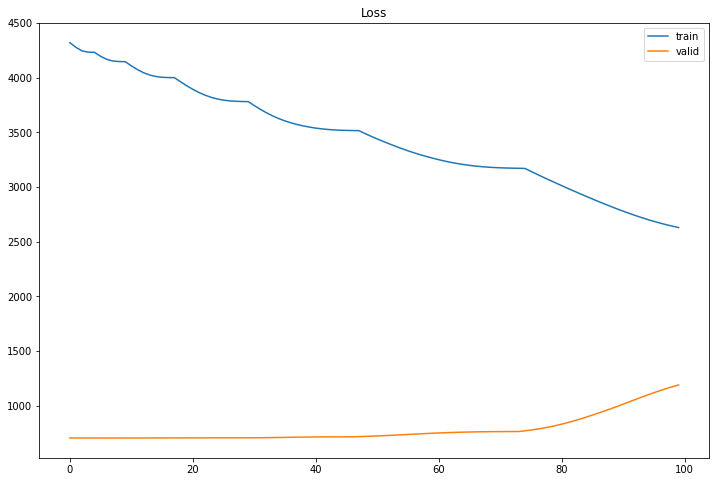

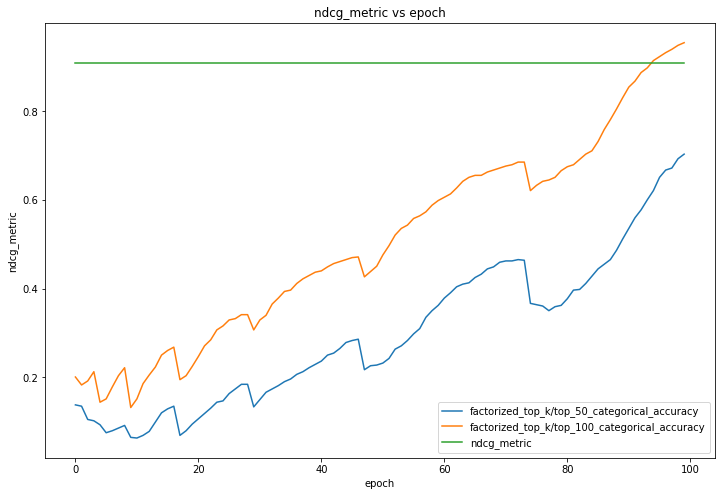

In [22]:
config = default_config.copy()

config['retrieval_weight'] = 1.0
config['rating_weight'] = 0.0
config['classification_weight'] = 0.0
config['flag_dcn_cross']=True

config['plot_metrics'] = config['rating_metrics']

#@markdown Which loss do you want to use for ranking task?
config['rating_loss_name']='mse' #@param ['listwise','mse','pairwise']
#@markdown Which model do you want to use?
config['model_type'] = 'VSN_L1_2task' #@param ['L1_2task', 'VSN_L1_2task']

#@markdown Do you use VSN for feature selection?
config['flag_vsn_deep_cross']= False #@param {type:'boolean'}

#@markdown Do you use SGR Scheduler?
config['flag_SGDRScheduler']= True #@param {type:'boolean'}

#@markdown What metric do you use to monitor the training?
config['monitor']= 'loss' #@param ['loss', 'val_ndcg_metric','val_RMSE','val_precision','val_recall','val_factorized_top_k/top_1_categorical_accuracy','val_factorized_top_k/top_5_categorical_accuracy','val_factorized_top_k/top_10_categorical_accuracy','val_factorized_top_k/top_50_categorical_accuracy','val_factorized_top_k/top_100_categorical_accuracy','val_loss','val_regularization_loss','val_total_loss']

model = create_fit_validate_evaluate_model(config=config)

As we see above, model performance increases with number of training epochs.

### rating task

To run rating task alone, we set 

- retrieval_weight=0              
- rating_weight=1 
- classification_weight=0


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)



Epoch 1: loss improved from inf to 74.99465, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 2: loss improved from 74.99465 to 70.76585, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 3: loss improved from 70.76585 to 66.88806, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 4: loss improved from 66.88806 to 65.11565, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 5: loss improved from 65.11565 to 64.96726, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 6: loss improved from 64.96726 to 57.88088, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 7: loss improved from 57.88088 to 51.87564, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 8: loss improved from 51.87564 to 48.56981, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 9: loss improved from 48.56981 to 47.54655, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 10: loss improved from 47.

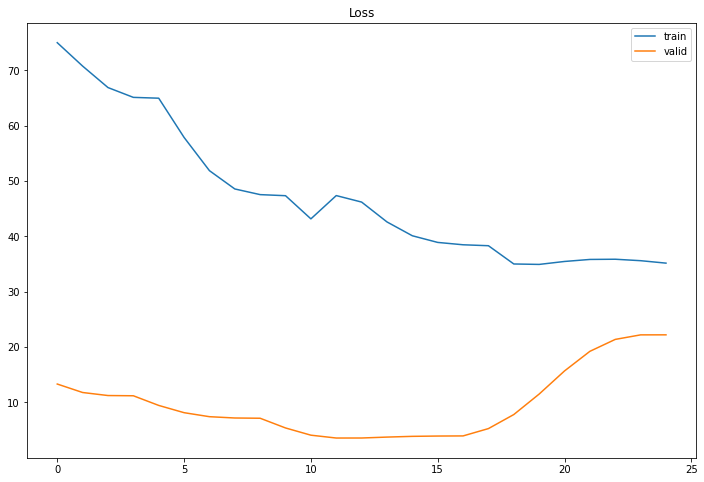

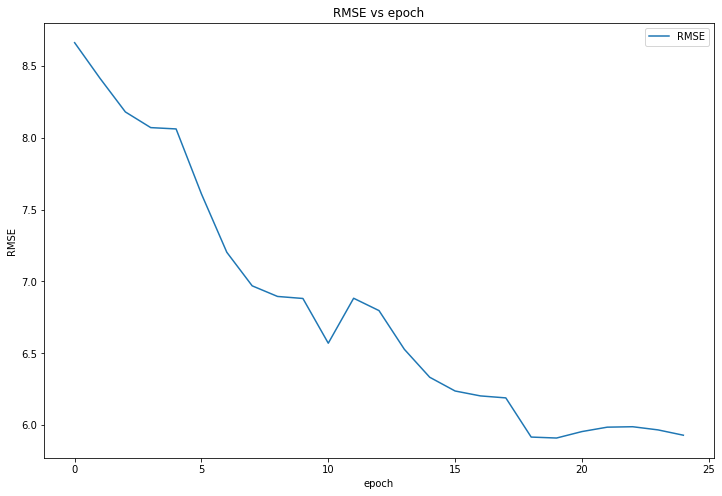

In [23]:
config = default_config.copy()
config['retrieval_weight'] = 0
config['rating_weight'] = 1.0
config['classification_weight'] = 0.0
config['plot_metrics'] = ['RMSE']

#@markdown Which optimizer do you want to use?
config['optimizer_name'] ='Adagrad' #@param ['Adam', 'Adadelta','Adagrad']

#@markdown Which optimizer do you want to use?
config['lr'] =0.1 #@param {type: "slider", min: 0.0, max: 1.0,  step:0.005}


#@markdown Which loss do you want to use for ranking task?
config['rating_loss_name']='mse' #@param ['listwise','mse','pairwise']

#@markdown Which model do you want to use?
config['model_type'] = 'VSN_L1_2task' #@param ['L1_2task', 'VSN_L1_2task']

#@markdown Do you use VSN for feature selection?
config['flag_vsn_deep_cross']= False #@param {type:'boolean'}

#@markdown Do you use SGR Scheduler?
config['flag_SGDRScheduler']= True #@param {type:'boolean'}

#@markdown What metric do you use to monitor the training?
config['monitor']= 'loss' #@param ['loss', 'val_ndcg_metric','val_RMSE','val_precision','val_recall','val_factorized_top_k/top_1_categorical_accuracy','val_factorized_top_k/top_5_categorical_accuracy','val_factorized_top_k/top_10_categorical_accuracy','val_factorized_top_k/top_50_categorical_accuracy','val_factorized_top_k/top_100_categorical_accuracy','val_loss','val_regularization_loss','val_total_loss']

model = create_fit_validate_evaluate_model(config=config)

### retrieval + rating (2-task model)

To run retrieval + rating tasks, we set 

- retrieval_weight=x, where 0<=x<=1
- rating_weight=1-x
- classification_weight=0


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)



Epoch 1: loss improved from inf to 2964.72729, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 2: loss improved from 2964.72729 to 2920.96265, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 3: loss improved from 2920.96265 to 2892.98120, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 4: loss improved from 2892.98120 to 2883.89136, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 5: loss improved from 2883.89136 to 2883.21655, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 6: loss improved from 2883.21655 to 2856.65479, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 7: loss improved from 2856.65479 to 2838.31641, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 8: loss improved from 2838.31641 to 2828.59448, saving model to /content/drive/My Drive/fast_tfrs/model/

Epoch 9: loss improved from 2828.59448 to 2825.48560, saving model to /content/drive/My Drive/fast_tfrs/model/

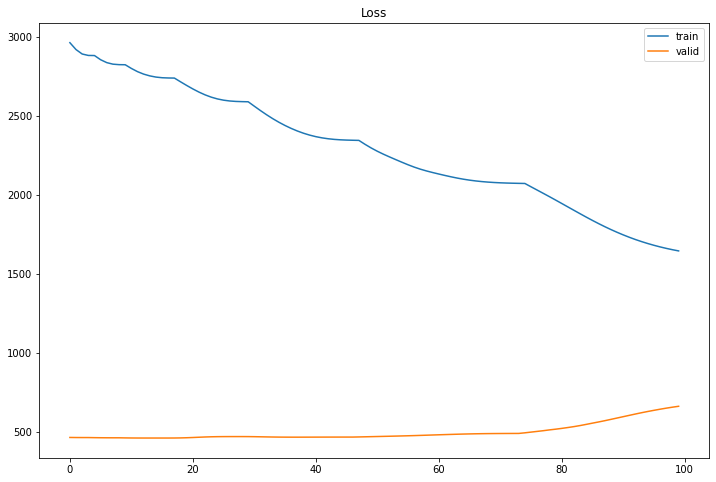

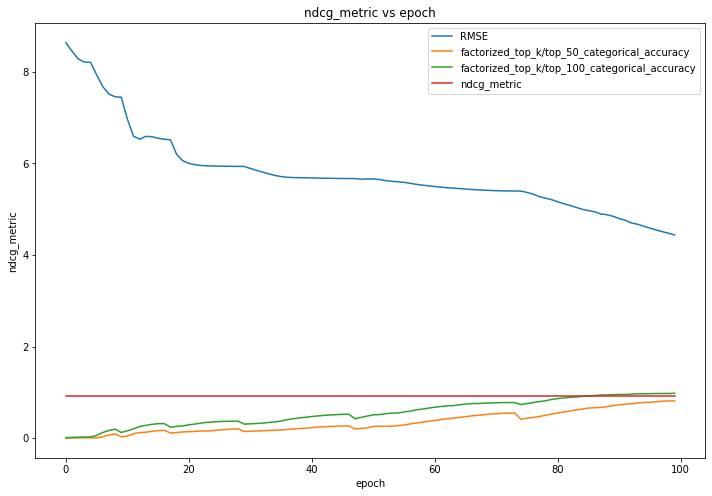

In [24]:
config = default_config.copy()
config['retrieval_weight'] = 0.65 #@param {type: "slider", min: 0.0, max: 1.0,  step:0.05}
config['rating_weight'] = 1 - config['retrieval_weight']
config['plot_metrics'] = ['RMSE'] + list(config['rating_metrics'])

#@markdown Which loss do you want to use for ranking task?
config['rating_loss_name']='mse' #@param ['listwise','mse','pairwise']

#@markdown Which model do you want to use?
config['model_type'] = 'VSN_L1_2task' #@param ['L1_2task', 'VSN_L1_2task']

#@markdown Do you use VSN for feature selection?
config['flag_vsn_deep_cross']= False #@param {type:'boolean'}

#@markdown Do you use SGR Scheduler?
config['flag_SGDRScheduler']= True #@param {type:'boolean'}

#@markdown What metric do you use to monitor the training?
config['monitor']= 'loss' #@param ['loss', 'val_ndcg_metric','val_RMSE','val_precision','val_recall','val_factorized_top_k/top_1_categorical_accuracy','val_factorized_top_k/top_5_categorical_accuracy','val_factorized_top_k/top_10_categorical_accuracy','val_factorized_top_k/top_50_categorical_accuracy','val_factorized_top_k/top_100_categorical_accuracy','val_loss','val_regularization_loss','val_total_loss']

model = create_fit_validate_evaluate_model(config=config)

## Model Serving 

Now we have our multi-task model fitted on the trainning data, we can apply it on test data to get predictions on rating,  classification. At the same time, the model convert test data from its raw form to numeric vectors e.g. its user embeddings and item embeddings. 


To get recommendations of items for a query user, we can 

- construct a items-user dataset
- apply model to this dataset and get predicted ratings
- rank the predicted ratings descendingly and take the top ones as recommendations

In [25]:
recommend_items_to_user(model, 
                        u_id=unique_user_ids[1], 
                        top_k=5,
                        global_vars=global_vars,
                        global_data=global_data,
                        )

7      rio do sul
505    rio do sul
907    rio do sul
204    rio do sul
592    rio do sul
476    rio do sul
490    rio do sul
971    rio do sul
977    rio do sul
469    rio do sul
579    rio do sul
408    rio do sul
942    rio do sul
304    rio do sul
717    rio do sul
2      rio do sul
791    rio do sul
3      rio do sul
878    rio do sul
4      rio do sul
68     rio do sul
18     rio do sul
720    rio do sul
97     rio do sul
113    rio do sul
923    rio do sul
957    rio do sul
142    rio do sul
871    rio do sul
19     rio do sul
510    rio do sul
75     rio do sul
827    rio do sul
170    rio do sul
62     rio do sul
909    rio do sul
973    rio do sul
254    rio do sul
564    rio do sul
477    rio do sul
792    rio do sul
88     rio do sul
947    rio do sul
429    rio do sul
100    rio do sul
58     rio do sul
997    rio do sul
383    rio do sul
47     rio do sul
103    rio do sul
663    rio do sul
116    rio do sul
470    rio do sul
263    rio do sul
949    rio do sul
516    rio

,product_id,quantity,price,order_purchase_timestamp,product_category_name_english,review_score,predicted_rating
68,595fac2a385ac33a80bd5114aec74eb8,1,142.5,1.502e+09,perfumery,2,27.914
831,fe0c30fb2df4e35bc7319b277ddbdaa5,1,319.9,1.529e+09,signaling_and_security,4,17.271
198,d9bdf643d95cb89844c0da1a0df1d16e,1,145.0,1.507e+09,perfumery,4,15.161
204,0f91b6a95a57a43203a9b17de98960d9,2,140.0,1.507e+09,health_beauty,1,12.418
254,8f83335d6508c667813ff14dc437bc81,1,142.5,1.509e+09,perfumery,3,10.892


## Model save & reload


### Example: save & reload a model

In [26]:
# choose a trained model to save
model = model#best_model
weight_filepath=default_config['model_path']+'VSN_L1_model_weight'
config_filepath=default_config['model_path']+'VSN_L1_model_config.pkl'

# save your model
save_model(model, weight_filepath, config_filepath)

------key=bias_initializer is converted fr.<class 'NoneType'> into pd.DataFrame------
key=bin_cnt_cols is converted fr.<class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> into list
------key=candidate_embs_dic is converted fr.<class 'NoneType'> into pd.DataFrame------
------key=cached_train is converted fr.<class 'tensorflow.python.data.ops.dataset_ops.CacheDataset'> into pd.DataFrame------
------key=cached_valid is converted fr.<class 'tensorflow.python.data.ops.dataset_ops.CacheDataset'> into pd.DataFrame------
------key=cached_test is converted fr.<class 'tensorflow.python.data.ops.dataset_ops.CacheDataset'> into pd.DataFrame------
key=cat_cols is converted fr.<class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> into list
key=clf_metrics is converted fr.<class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> into list
------key=clf_optimizer is converted fr.<class 'keras.optimizers.optimizer_v2.adam.Adam'> into pd.DataFram

In [27]:
# reload your model
new_model = reload_model(df=df,
                        interactions=interactions,
                        items=items, 
                        weight_filepath=weight_filepath, 
                        config_filepath=config_filepath,
                        )

===== key=cached_train is converted from df back to tfds=====
===== key=cached_valid is converted from df back to tfds=====
===== key=cached_test is converted from df back to tfds=====
===== key=interactions is converted from df back to tfds=====
===== key=items is converted from df back to tfds=====


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


### checkpoint: expect predictions by reloaded model and the original model are the same

In [28]:
#dbck: expect to produce the same thing as model(dict(test_df.head(3)))
res = model(dict(test_df.head(10)))

new_res = new_model(dict(test_df.head(10)))

print(f"========================================================\nReloaded model performs the same as original model: {(new_res[-1].numpy()==res[-1].numpy()).all()} \n========================================================")


851           niteroi
852      campo mourao
853     foz do iguacu
854    rio de janeiro
855    rio de janeiro
856             natal
857          campinas
858        ponte nova
859           ibiraci
Name: customer_city, dtype: object. Consider rewriting this model with the Functional API.
851    1.529e+09
852    1.529e+09
853    1.529e+09
854    1.529e+09
855    1.530e+09
856    1.530e+09
857    1.530e+09
858    1.530e+09
859    1.530e+09
Name: order_purchase_timestamp, dtype: float64. Consider rewriting this model with the Functional API.
851    watches_gifts
852        perfumery
853    health_beauty
854        perfumery
855        perfumery
856        perfumery
857    watches_gifts
858    watches_gifts
859    watches_gifts
Name: product_category_name_english, dtype: object. Consider rewriting this model with the Functional API.
851    1
852    1
853    1
854    1
855    1
856    1
857    1
858    1
859    1
Name: quantity, dtype: object. Consider rewriting this model with the Function

## Model understanding
To understand how feature cross contribute to the model performance, we visualize the learned weights in our model. Here weight $W_{i,j}$ represent the learned importance of interaction between feature $i$ and feature $j$.

Ref: https://www.tensorflow.org/recommenders/examples/dcn

<Figure size 648x648 with 0 Axes>

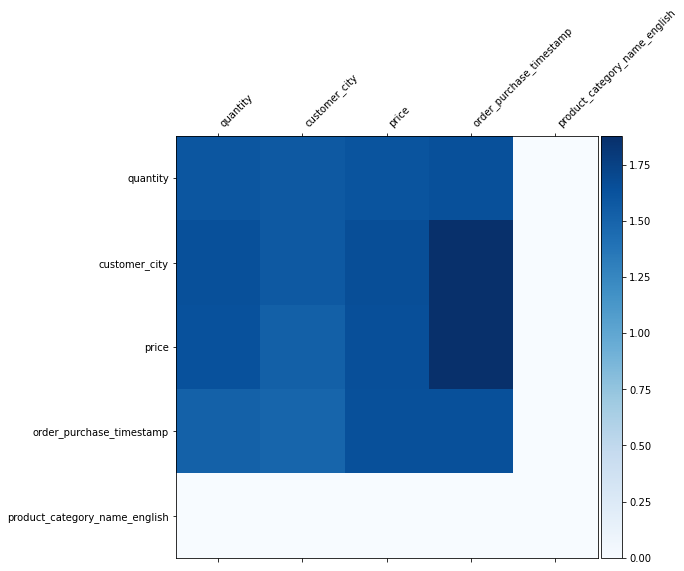

In [29]:
plot_cross_feature_importances(model=model)

## Get the best fast_tfrs model by Bayesian tuning




In [ ]:
from datetime import datetime
# datetime object containing current date and time
t0 = datetime.now()
print(f"===========start time = {t0}")

best_model, best_metrics, best_para = get_best_model(metric='factorized_top_k/top_100_categorical_accuracy',
                                                      model_config=default_config,
                                                      df=df,
                                                      interactions=interactions, 
                                                      items=items, 
                                                      cached_train=cached_train,
                                                      cached_valid=cached_valid,
                                                      cached_test=cached_test,
                                                      )

t1 = datetime.now()
print(f"===========finish time = {t1}")

#dbck: get the config for best_model
best_model_config = best_model.get_config()
best_model_config

===========start time = 2022-07-04 23:14:33.816739
|   iter    |  target   |   alpha   | dropou... | flag_u... |   l1_l2   |  layer_1  |  layer_2  |  layer_3  | learni... | loss_name | model_... | n_layers  | rating... | retrie... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


------Train data: Top-100 accuracy = [0.41167664527893066, 0.0, 0.002994012087583542, 0.26047903299331665, 0.9790419340133667, 0.38173651695251465, 0.576347291469574, 0.0, 0.11077844351530075, 0.25449103116989136, 0.16916167736053467, 0.38772454857826233, 0.35479041934013367, 0.688622772693634, 0.8577844500541687, 0.9565868377685547, 0.9940119981765747, 0.9895209670066833, 0.9970059990882874, 0.9970059990882874, 0.9985029697418213, 0.9985029697418213, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985029697418213, 0.9985029697418213, 0.9985029697418213, 0.9985029697418213, 0.9985029697418213, 0.9970059990882874, 0.9970059990882874, 0.9970059990882874, 0.9955089688301086, 0.9955089688301086, 0.9955089688301086, 0.9955089688301086, 0.9955089688301086, 0.9955089688301086, 0.9955089688301086, 0.9955089688301086, 0.9955089688301086].
1/1 [==============================] - 0s 122ms/step - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0000e+00 - pr